# Descriptive statistics

Tests to determine if time series is stationary, if it's independent and if
two series demonstrate causality.

### Dickey-Fuller Test

This is test for stationarity.. to determine whether a series is stationary
we can use the augmented Dicky-fuller test.

This performs a test in the form of a classic null hypothesis test and returns a p value


<img 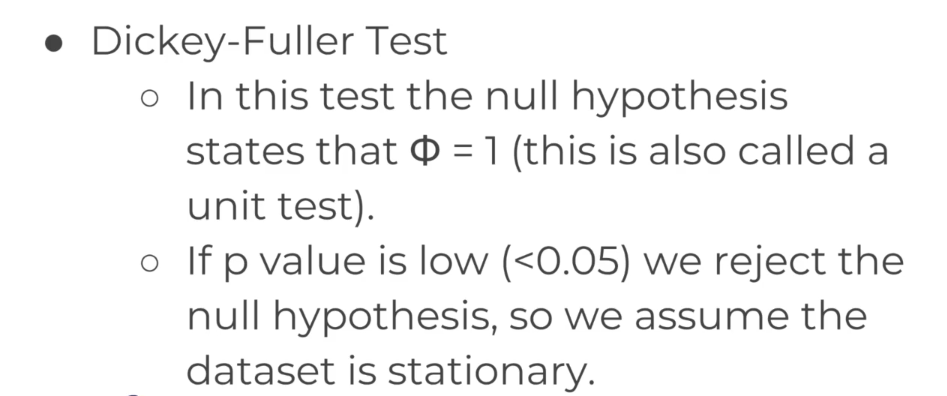

<img 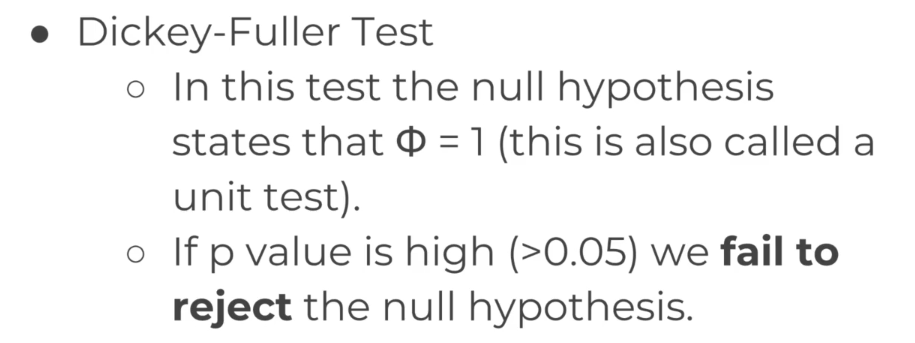

## Granger Causuality Tests

This is a hypothesis test to determine if one time series is useful in forecasting another one

While it is fairly easy to measure correlations between series it's another thing to observe
changes in one series correalted to changes in another after a consistent amount of time

This test is used to see if there is an indication of causality, but keep in mind,it could alway be some
outside factor unaccounted for

## AIC - Akaike Information Criterion

Developed by Hirotugu Akaike in 1971

AIC evaluates a collection of models and estimates the quality of each model realtive to others.

Penalties are provided for the number of parameters used in an effort to thwart overfitting.

Overfitting results in  performing very well on training Data, but poorly on new unseen data.

## BIC - Bayesian Information Criterion

Similar to Aic, just the mathematics behind the model comparisions utilizes a Baysian approach.

##### Seasonality plots
<img 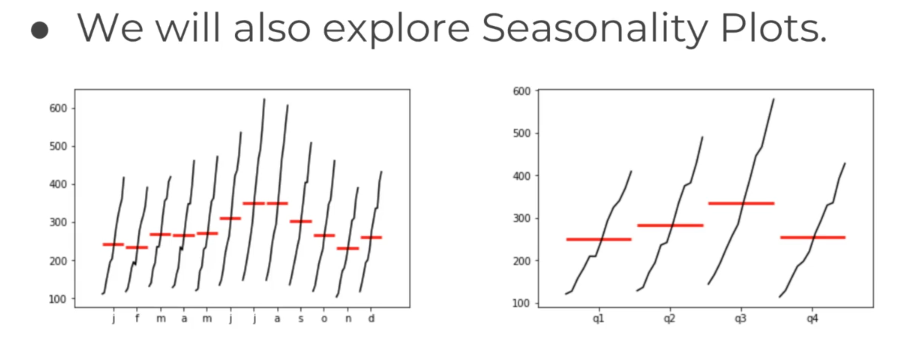

In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')


In [4]:
df1 = pd.read_csv('../Data/airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

In [5]:
df2 = pd.read_csv('../Data/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

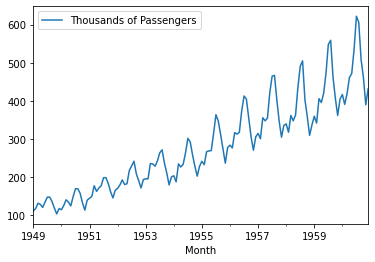

In [7]:
df1.plot() # Non-stationarity

#### Applying dicky-fuller test to check if series is stationary or not

In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
adfuller(df1['Thousands of Passengers'])

(0.815368879206046,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [10]:
help(adfuller)

Help on function adfuller in module statsmodels.tsa.stattools:

adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
    Augmented Dickey-Fuller unit root test.
    
    The Augmented Dickey-Fuller test can be used to test for a unit root in a
    univariate process in the presence of serial correlation.
    
    Parameters
    ----------
    x : array_like, 1d
        The data series to test.
    maxlag : int
        Maximum lag which is included in test, default 12*(nobs/100)^{1/4}.
    regression : {'c','ct','ctt','nc'}
        Constant and trend order to include in regression.
    
        * 'c' : constant only (default).
        * 'ct' : constant and trend.
        * 'ctt' : constant, and linear and quadratic trend.
        * 'nc' : no constant, no trend.
    
    autolag : {'AIC', 'BIC', 't-stat', None}
        Method to use when automatically determining the lag.
    
        * if None, then maxlag lags are used.
        * if 'AIC' (default) or 

In [12]:
dftest = adfuller(df1['Thousands of Passengers'])
dfout = pd.Series(dftest[0:4],index=['ADF Test statistics','p-value','#Lags Used','#Observations'])

In [13]:
for key,val in dftest[4].items():
    dfout[f'Critical Value({key})'] = val

In [14]:
dfout

ADF Test statistics      0.815369
p-value                  0.991880
#Lags Used              13.000000
#Observations          130.000000
Critical Value(1%)      -3.481682
Critical Value(5%)      -2.884042
Critical Value(10%)     -2.578770
dtype: float64

In [15]:
# here we can see p value is 0.99

### Function for running the augmented Dickey-Fuller test
Since we'll use it frequently in the upcoming forecasts, let's define a function we can copy into future notebooks for running the augmented Dickey-Fuller test. Remember that we'll still have to import <tt>adfuller</tt> at the top of our notebook.

In [16]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [17]:
adf_test(df1['Thousands of Passengers'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


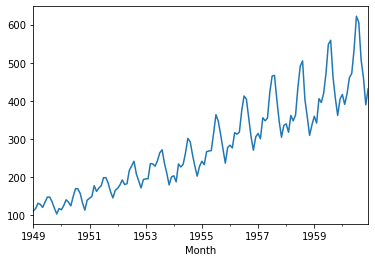

In [18]:
df1['Thousands of Passengers'].plot()

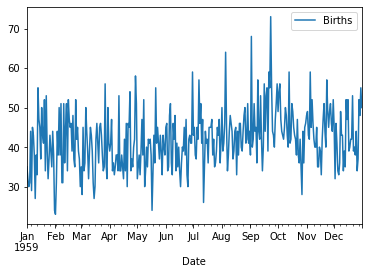

In [20]:
df2.plot()

In [22]:
adf_test(df2['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.808291
p-value                   0.000052
# lags used               6.000000
# observations          358.000000
critical value (1%)      -3.448749
critical value (5%)      -2.869647
critical value (10%)     -2.571089
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


## Granger Causaulty Test

# Granger Causality Tests
The <a href='https://en.wikipedia.org/wiki/Granger_causality'>Granger causality test</a> is a a hypothesis test to determine if one time series is useful in forecasting another. While it is fairly easy to measure correlations between series - when one goes up the other goes up, and vice versa - it's another thing to observe changes in one series correlated to changes in another after a consistent amount of time. This <em>may</em> indicate the presence of causality, that changes in the first series influenced the behavior of the second. However, it may also be that both series are affected by some third factor, just at different rates. Still, it can be useful if changes in one series can predict upcoming changes in another, whether there is causality or not. In this case we say that one series "Granger-causes" another.

In the case of two series, $y$ and $x$, the null hypothesis is that lagged values of $x$ do <em>not</em> explain variations in $y$.<br>
In other words, it assumes that $x_t$ doesn’t Granger-cause $y_t$.

The stattools <tt><strong>grangercausalitytests</strong></tt> function offers four tests for granger non-causality of 2 timeseries

For this example we'll use the samples.csv file, where columns 'a' and 'd' are stationary datasets.

In [23]:
df3 = pd.read_csv('../Data/samples.csv',index_col=0,parse_dates=True)
df3.index.freq = 'MS'

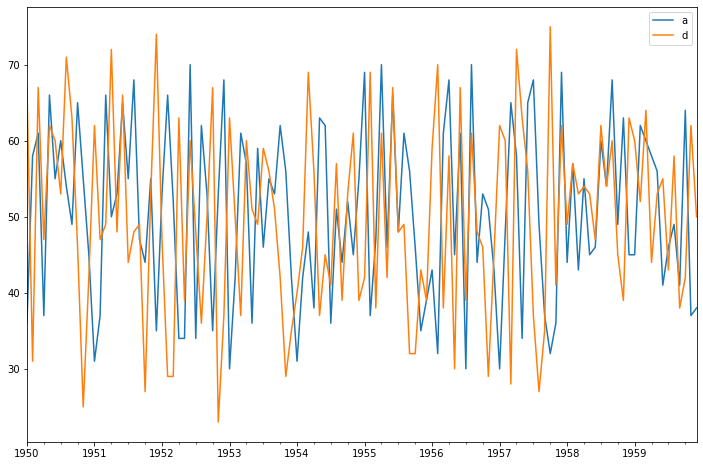

In [24]:
df3[['a','d']].plot(figsize=(12,8))

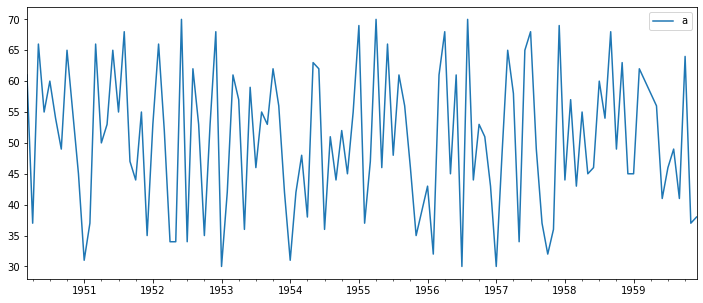

In [25]:
df3['a'].iloc[2:].plot(figsize=(12,5),legend=True)

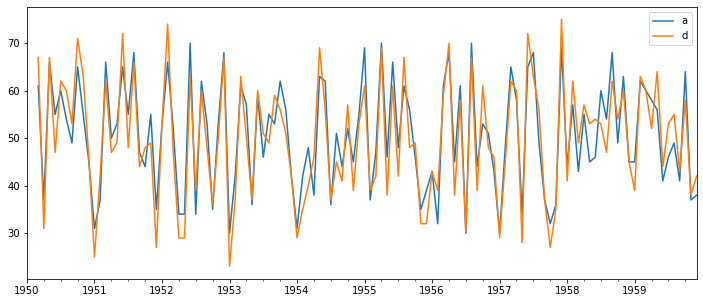

In [26]:
df3['a'].iloc[2:].plot(figsize=(12,5),legend=True)
df3['d'].shift(2).plot(legend=True)

as we can see here if 2 days after there is some change in d a is reflecting that change.
which determines that d has casuality on a

In [28]:
from statsmodels.tsa.stattools import grangercausalitytests

In [30]:
grangercausalitytests(df3[['a','d']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.7492  , p=0.1860  , df=1
likelihood ratio test: chi2=1.7365  , p=0.1876  , df=1
parameter F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=597.3806, p=0.0000  , df=2
likelihood ratio test: chi2=212.6514, p=0.0000  , df=2
parameter F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=602.2669, p=0.0000  , df=3
likelihood ratio test: chi2=212.4789, p=0.0000  , df=3
parameter F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3


So from above result we will check for the lags showing lowest p value
So we can see at lag 2 p value is 0 so we can consider that

In [31]:
#cheking causality for column b
grangercausalitytests(df3[['b','d']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.5619  , p=0.2114  , df=1
likelihood ratio test: chi2=1.5517  , p=0.2129  , df=1
parameter F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=0.9086  , p=0.6349  , df=2
likelihood ratio test: chi2=0.9051  , p=0.6360  , df=2
parameter F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5333  , p=0.6604  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=1.7018  , p=0.6365  , df=3
likelihood ratio test: chi2=1.6895  , p=0.6393  , df=3
parameter F test:         F=0.5333  , p=0.6604  , df_denom=110, df_num=3


We check if p value is 0.05 to see if there is any casualtiy.. if we get values less that 0.05 we can say there is causuality

If there is no causality we will get p value greater than 0.05

In [34]:
np.random.seed(42)

df = pd.DataFrame(np.random.randint(20,30,(50,2)),columns=['test','predictions'])

In [35]:
df.head()

,test,predictions
0,26,23
1,27,24
2,26,29
3,22,26
4,27,24


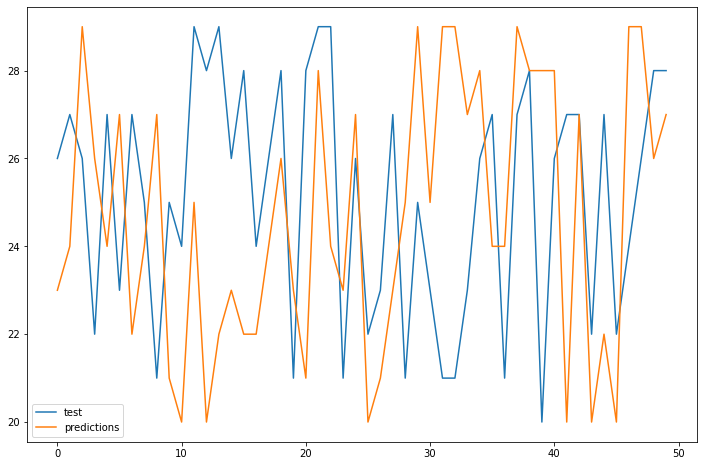

In [37]:
df.plot(figsize=(12,8))

In [38]:
# on this dummy generated data we can evaluate our test and prediction using MSE,RMSE,MAE

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import mse,rmse,meanabs

In [39]:
mse(df['test'],df['predictions'])

17.02

In [40]:
rmse(df['test'],df['predictions'])

4.125530268947253

In [41]:
meanabs(df['test'],df['predictions'])

3.54

#### Visualizing Seasonality and Quarterly data

In [43]:
df = pd.read_csv('../Data/airline_passengers.csv',index_col='Month',parse_dates=True)

In [44]:
df.index.freq = 'MS'

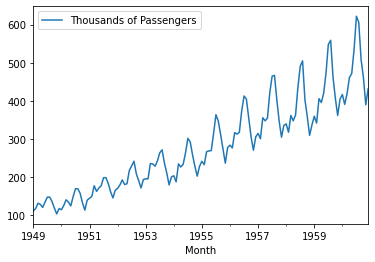

In [45]:
df.plot()

By looking at the data it might not be possible to idenify when the seasonality has happened.


In [47]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot

so if we have timestamp index then statsmodel seperates our data into months and quarters

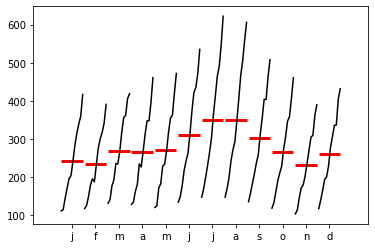

In [48]:
month_plot(df['Thousands of Passengers']);

so here we can see there is upsurge in june and july month and dec

#### checking by Quarterly

In [49]:
dfq = df['Thousands of Passengers'].resample(rule='Q').mean()

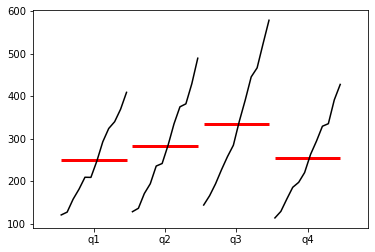

In [51]:
quarter_plot(dfq);

So here we can see there is seasonality in Q3